In [1]:
import sys, os, time
import torch
sys.path.append("../src/")
from run_pdebench_finetuning import get_args, get_model, build_pdebench_dataset
from engine_for_pdebench_finetuning import get_targets, unnorm_batch
import utils
from einops import rearrange
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
model_dir = 'pdebench_finetuning/ssv2_b/final_runs/ssv2_b_rand_128_0.08'
out_filename = 'ssv2_b_rand_128_0.08.mp4'

args_json = os.path.join(utils.get_ceph_dir(), model_dir, "args.json")
args = utils.load_args(args_json)

args.num_workers = 1
args.device = 'cuda:0'
args.checkpoint = os.path.join(model_dir, 'checkpoint-499')

In [3]:
n_pred_frames = 20

In [4]:
print("Dataset:\t\t", args.data_set)
print("Fields:\t\t\t", args.fields)
print("Model:\t\t\t", args.model)
print("Checkpoint:\t\t", args.checkpoint)
print("Batch size:\t\t", args.batch_size)
print("Number of workers:\t", args.num_workers)
print("Mask type:\t\t", args.mask_type)
print("Mask ratio:\t\t", args.mask_ratio)
print("Norm target mode:\t", args.norm_target_mode)
print("Num frames:\t\t", args.num_frames)
print("Device:\t\t\t", args.device)

Dataset:		 compNS_rand
Fields:			 ['Vx', 'Vy', 'density', 'pressure']
Model:			 pretrain_videomae_base_patch16_128_4chan_18f
Checkpoint:		 pdebench_finetuning/ssv2_b/final_runs/ssv2_b_rand_128_0.08/checkpoint-499
Batch size:		 1
Number of workers:	 1
Mask type:		 last_frame
Mask ratio:		 0.9
Norm target mode:	 last_frame
Num frames:		 18
Device:			 cuda:0


In [5]:
device = torch.device(args.device)

# Load model
model = get_model(args)
model.to(device)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model loaded")
print('number of params: {} M'.format(n_parameters / 1e6))

# Load dataset
dataset = build_pdebench_dataset(args, set_type='test')
dataset.timesteps = 21
dataset.random_start = False

# Data loader
# sampler = torch.utils.data.RandomSampler(dataset)
sampler = torch.utils.data.SequentialSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, sampler=sampler,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
        worker_init_fn=utils.seed_worker)

Creating model: pretrain_videomae_base_patch16_128_4chan_18f
Position interpolate from 8x14x14 to 9x8x8
Position interpolate from 8x14x14 to 9x8x8
Adapting checkpoint for PDEBench
Model loaded
number of params: 94.80128 M
Loading dataset file /mnt/home/gkrawezik/ceph/AI_DATASETS/PDEBench/2D/CFD/2D_Train_Rand/2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5
Raw dataset compNS_rand has 10000 samples of shape (128, 128) and 21 timesteps.


In [6]:
loss_func = nn.MSELoss()

max_examples = 1

model.eval()
for samples_base, masks in data_loader:
    samples_base = samples_base.to(device, non_blocking=True)

    bool_masked_pos = masks.to(device, non_blocking=True).flatten(1).to(torch.bool)

    p0, p1, p2 = 2, args.patch_size[0], args.patch_size[1]
    h, w = args.input_size // p1, args.input_size // p2
    nchan = samples_base.shape[1]
    
    # Extend samples_base
    samples_base = torch.cat([samples_base,
                              samples_base[:, :, -1:].repeat(1, 1, n_pred_frames-2, 1, 1)], dim=2)

    for i in range(args.num_frames, args.num_frames + n_pred_frames + 2):
        samples = samples_base[:, :, i-args.num_frames:i]

        with torch.no_grad():
            outputs = model(samples, bool_masked_pos)
            outputs_unnorm = unnorm_batch(outputs,
                                        norm_mode=args.norm_target_mode,
                                        patch_size=(p0, p1, p2),
                                        context=samples,
                                        bool_masked_pos=bool_masked_pos)
            
            recon_full = rearrange(samples, 'b c (t p0) (h p1) (w p2) -> b (t h w) (p0 p1 p2 c)', p0=p0, p1=p1, p2=p2)
            recon_full[bool_masked_pos] = outputs_unnorm.flatten(start_dim=0, end_dim=1)
            recon_full = rearrange(recon_full, 'b (t h w) (p0 p1 p2 c) -> b c (t p0) (h p1) (w p2)', p0=p0, p1=p1, p2=p2, h=h, w=w)
            samples_base[:, :, i-2] = recon_full[:, :, -2]

            # We only compute the loss on the first predicted frame
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], p0, p1, p2, nchan)[:, 0, :, :, :]
            outputs = outputs.reshape(outputs.shape[0], outputs.shape[1], -1)
            
    samples_base = samples_base[:, :, :-1]
    max_examples -= 1
    if max_examples == 0:
        break

In [7]:
def plot_reconstruction(truth, recon):
    truth = truth[0].cpu().numpy()
    recon = recon[0].cpu().numpy()

    nframes = truth.shape[1]
    
    vmin = np.min(truth, axis=(-1, -2, -3))
    vmax = np.max(truth, axis=(-1, -2, -3))

    fig, axs = plt.subplots(nframes, 2*len(args.fields), figsize=(6*len(args.fields), 3*nframes), sharex=True, sharey=True)
    for i in range(nframes):
        for j in range(len(args.fields)):
            axs[i, 2*j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
            axs[i, 2*j+1].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
        axs[i, 0].set_ylabel('Frame {}'.format(i))
    for j in range(len(args.fields)):
        axs[0, 2*j].set_title(args.fields[j] + ' (truth)')
        axs[0, 2*j+1].set_title(args.fields[j] + ' (recon)')
    fig.tight_layout()
    plt.show()

In [8]:
def make_video(recon, out_filename):
    recon = recon[0].cpu().numpy()

    nframes = recon.shape[1]

    fps = 1
    nSeconds = nframes

    vmin = np.min(recon, axis=(-1, -2, -3))
    vmax = np.max(recon, axis=(-1, -2, -3))

    ims = [None,] * len(args.fields)

    i = 0
    fig, axs = plt.subplots(1, len(args.fields), figsize=(3*len(args.fields), 3), sharex=True, sharey=True)
    for j in range(len(args.fields)):
        ims[j] = axs[j].imshow(recon[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
    for j in range(len(args.fields)):
        axs[j].set_title(args.fields[j] + ' - Frame {}'.format(i))
    fig.tight_layout()

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        for j in range(len(args.fields)):
            ims[j].set_array(recon[j, i, :, :])
            suffix = '(Context)' if i < args.num_frames - 2 else '(Prediction)'
            axs[j].set_title(args.fields[j] + ' - Frame {} '.format(i) + suffix)
        return ims

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = nSeconds * fps,
                                interval = 1000 / fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, bitrate=1800)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

.......................................

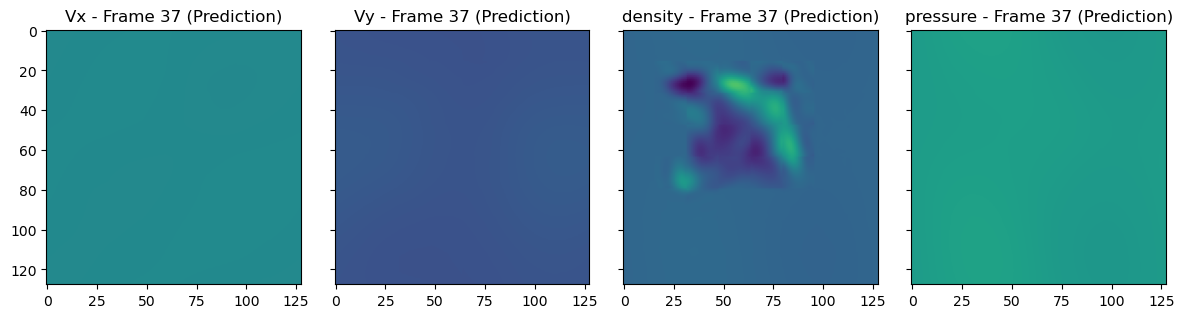

In [9]:
make_video(samples_base, out_filename)